In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
data_csv =pd.read_csv("./data_input/data_rnn.csv", usecols=[1])
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype("float32")
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
look_back = 30
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = [dataset[i: (i + look_back)]]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
dataX, dataY = create_dataset(dataset, look_back)
#划分测试集的数量和训练集的数量
alpha = 0.5
train_size = int(len(dataX) * alpha)
test_size = len(dataX) - train_size
train_x = dataX[:train_size]
train_y = dataY[:train_size]
test_x = dataX[train_size:]
test_y = dataY[train_size:]
train_x = torch.from_numpy(train_x)
train_x = train_x.squeeze(3)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

## 数据准备完毕，下方是：定义模型

In [10]:
class lstm_reg(torch.nn.Module):
    def __init__(self, input_size, hidden_size, out_size = 1,num_layers = 2) -> None:
        super(lstm_reg, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers)
        self.reg = torch.nn.Linear(hidden_size, out_size)

    def forward(self, x):
        #seq, bacth_size, hidden
        #有train_size个数据（seq）、每一组有look_back个
        x, _ = self.lstm(x) 
        seq, batch_size, hidden_size = x.shape
        x = x.reshape(seq * batch_size, hidden_size)
        x = self.reg(x)
        x.reshape(seq, batch_size, -1)
        return x

net = lstm_reg(look_back, 16)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [11]:
for param_tensor in net.state_dict(): 
   print(param_tensor, '\t', net.state_dict()[param_tensor].size())

lstm.weight_ih_l0 	 torch.Size([64, 30])
lstm.weight_hh_l0 	 torch.Size([64, 16])
lstm.bias_ih_l0 	 torch.Size([64])
lstm.bias_hh_l0 	 torch.Size([64])
lstm.weight_ih_l1 	 torch.Size([64, 16])
lstm.weight_hh_l1 	 torch.Size([64, 16])
lstm.bias_ih_l1 	 torch.Size([64])
lstm.bias_hh_l1 	 torch.Size([64])
reg.weight 	 torch.Size([1, 16])
reg.bias 	 torch.Size([1])


In [12]:
running_loss = 0.0
for epoch in range(2200):

    var_x = Variable(train_x).to(torch.float32)
    var_y = Variable(train_y).to(torch.float32).reshape(train_size, -1)

   
    out = net(var_x)
    loss = criterion(out, var_y)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    
    
    optimizer.step()
    if (epoch + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(epoch + 1, running_loss / 100))
        running_loss = 0.0

Epoch: 100, Loss: 0.00362
Epoch: 200, Loss: 0.00056
Epoch: 300, Loss: 0.00027
Epoch: 400, Loss: 0.00014
Epoch: 500, Loss: 0.00008
Epoch: 600, Loss: 0.00012
Epoch: 700, Loss: 0.00003
Epoch: 800, Loss: 0.00003
Epoch: 900, Loss: 0.00002
Epoch: 1000, Loss: 0.00001
Epoch: 1100, Loss: 0.00002
Epoch: 1200, Loss: 0.00000
Epoch: 1300, Loss: 0.00001
Epoch: 1400, Loss: 0.00001
Epoch: 1500, Loss: 0.00000
Epoch: 1600, Loss: 0.00000
Epoch: 1700, Loss: 0.00001
Epoch: 1800, Loss: 0.00000
Epoch: 1900, Loss: 0.00000
Epoch: 2000, Loss: 0.00001
Epoch: 2100, Loss: 0.00000
Epoch: 2200, Loss: 0.00000


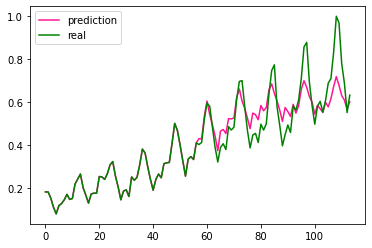

In [13]:
net = net.eval() # 转换成测试模式
data_x = dataX.reshape(-1, 1, look_back)
data_x = torch.from_numpy(data_x).to(torch.float32)
var_data = Variable(data_x)
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.view(-1).data.numpy()
plt.plot(pred_test, 'deeppink', label='prediction')
plt.plot(dataset[look_back:], 'green', label='real')
plt.legend(loc='best')

In [14]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(dataset[look_back:], pred_test)
print(MSE)

0.0042698104
